In [1]:
import numpy as np
import matplotlib.pyplot as plt

import product_fem as pf
import fenics
import inference
rng = np.random.default_rng()

*Modified from `example_usage.ipynb`.*

In [2]:
nx, ny = 15, 10 # mesh resolution
mesh = fenics.RectangleMesh(fenics.Point(0, 0), fenics.Point(1.5, 1), nx-1, ny-1)
V = fenics.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)

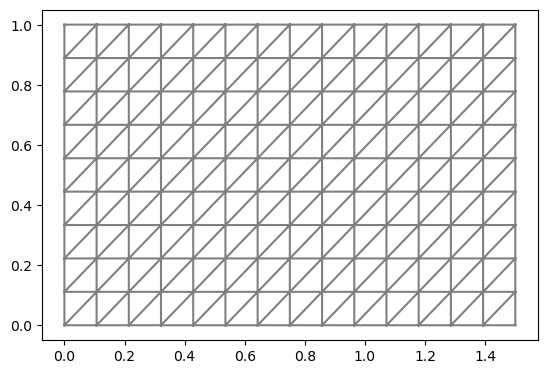

In [3]:
fenics.plot(mesh);

In [4]:
u_bdy = 0.5 # or could be a callable
epsilon = 1e-2
eqn = pf.equations.HittingTimes(W, u_bdy, epsilon)

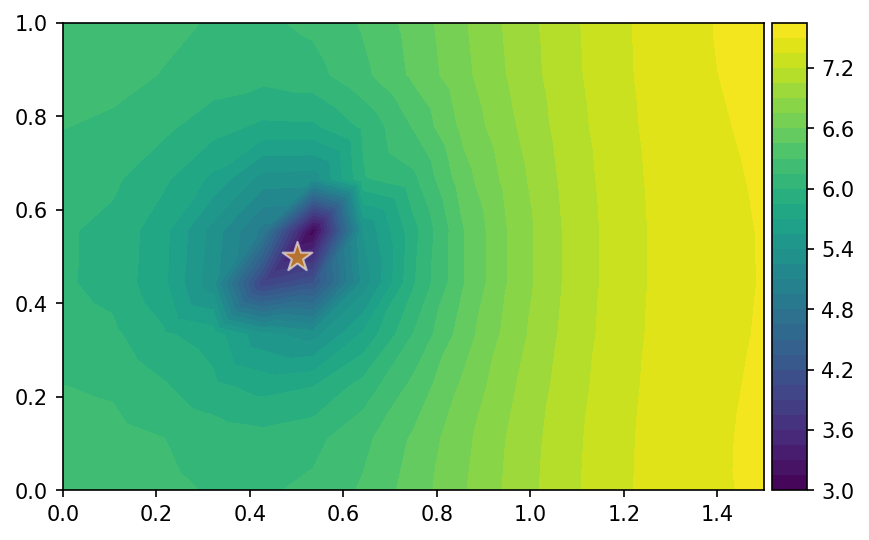

In [5]:
m_data = eqn.control
m_arr = m_data.array().copy()
u_data = eqn.solve(m_data)
u_data.plot([0.5, 0.5]);

In [6]:
reg = {'l2': [1e-6, 1e-4], 'smoothing': [1e-1, 1e-1]}
J = pf.LossFunctional(u_data, m_data, reg)
Jhat = pf.ReducedLossFunctional(eqn, J)
print(Jhat(m_data)) # loss at truth

7.206795208773036e-05


In [20]:
# test L2 error is minimized at the truth
assert np.isclose(J.l2_error(u_data), 0.0)
assert np.isclose(np.sum(np.abs(J.l2_error.derivative(u_data))), 0.0)

temp_array = u_data.array.copy()
for sd in [0.01, 0.1, 0.5, 10]:
    temp_array += rng.normal(loc=0, scale=sd, size=len(temp_array))
    v = pf.transforms.array_to_ProductFunction(temp_array, W)
    l2_err = J.l2_error(v)
    assert l2_err > 0
    assert not np.isclose(l2_err, 0.0)
    assert not np.isclose(np.sum(np.abs(J.l2_error.derivative(v))), 0.0)

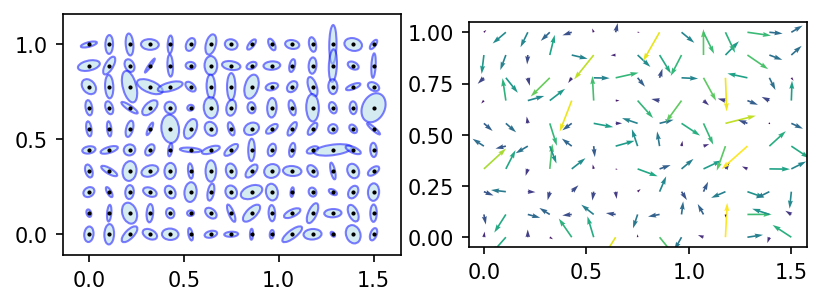

In [33]:
temp_array = rng.normal(loc=0, scale=0.5, size=len(eqn.control.array()))
eqn.control.update(temp_array)
eqn.plot_control();

In [34]:
# test L2 regularization minimized at zero
m = eqn.control
m.update(np.zeros(len(m.array())))
assert J.l2_reg(m) == 0
for sd in [0.01, 0.1, 0.5, 10]:
    temp_array = rng.normal(loc=0, scale=sd, size=len(m.array()))
    m.update(temp_array)
    assert J.l2_reg(m) > 0

In [36]:
# test smoothing regularization minimized on a flat surface
m.update(np.zeros(len(m.array())))
assert J.smoothing_reg(m) == 0
m.update(np.ones(len(m.array())))
assert J.smoothing_reg(m) == 0

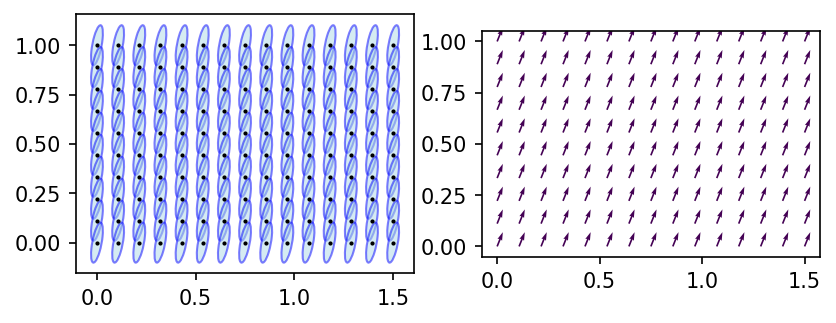

In [69]:
N = int(len(eqn.control.array())/5)
b_array = np.zeros((N, 2))
b_array[:,0] = 2.0
b_array[:,1] = 5.0
sig_array = np.zeros((N, 3))
sig_array[:, 0] = 0.0
sig_array[:, 1] = 1.0
sig_array[:, 2] = 2.0
temp_array = np.concatenate([b_array.flatten(), sig_array.flatten()])
m = eqn.control
m.update(temp_array)
assert J.smoothing_reg(m) == 0
eqn.plot_control();

In [72]:
m = eqn.control
for _ in range(50):
    b_array = np.zeros((N, 2))
    b_array[:,0] = rng.normal() * rng.choice([0,1])
    b_array[:,1] = rng.normal() * rng.choice([0,1])
    sig_array = np.zeros((N, 3))
    sig_array[:, 0] = rng.normal() * rng.choice([0,1])
    sig_array[:, 1] = rng.normal() * rng.choice([0,1])
    sig_array[:, 2] = rng.normal() * rng.choice([0,1])
    temp_array = np.concatenate([b_array.flatten(), sig_array.flatten()])
    m.update(temp_array)
    assert J.smoothing_reg(m) == 0

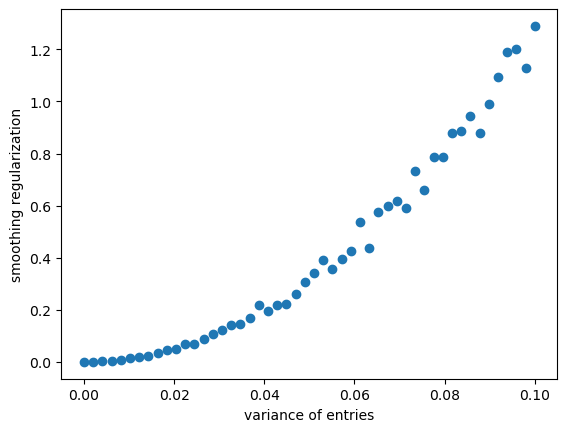

In [77]:
regvals = np.zeros(50)
svals = np.linspace(0, 0.1, len(out))
for j, s in enumerate(svals):
    b_array = np.zeros((N, 2))
    b_array[:,0] = rng.normal(scale=s, size=N)
    b_array[:,1] = rng.normal(scale=s, size=N)
    sig_array = np.zeros((N, 3))
    sig_array[:, 0] = rng.normal(scale=s, size=N)
    sig_array[:, 1] = rng.normal(scale=s, size=N)
    sig_array[:, 2] = rng.normal(scale=s, size=N)
    temp_array = np.concatenate([b_array.flatten(), sig_array.flatten()])
    m.update(temp_array)
    regvals[j] = J.smoothing_reg(m)

fig, ax = plt.subplots()
ax.scatter(svals, regvals)
ax.set_xlabel("variance of entries")
ax.set_ylabel("smoothing regularization");

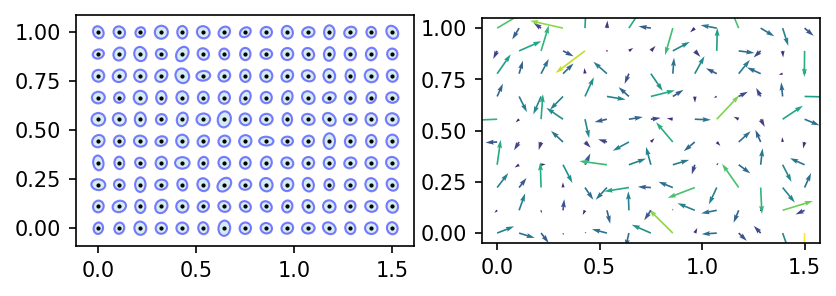

In [78]:
eqn.plot_control();

# Check boundary conditions

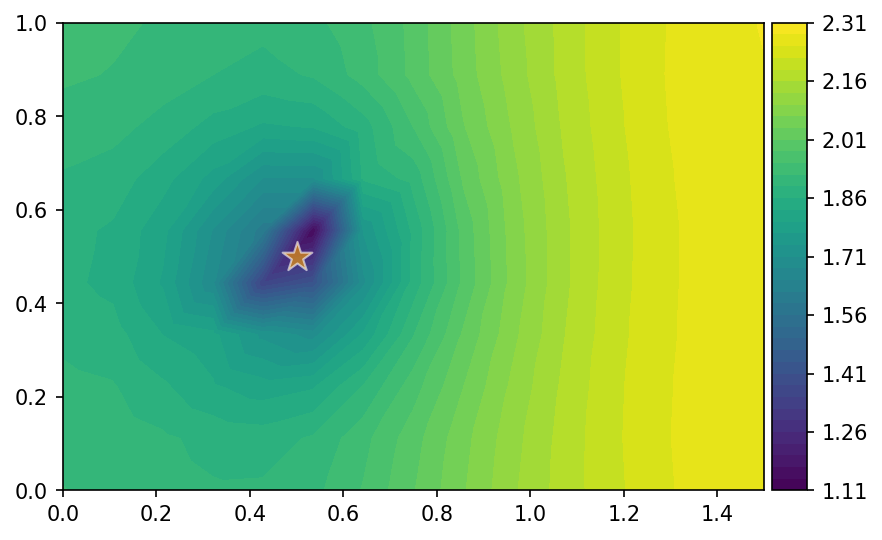

In [80]:
m = eqn.control
u = eqn.solve(m)
u.plot([0.5, 0.5]);

In [94]:
xlims, ylims = (0.0, 1.5), (0.0, 1.0)
assert u((xlims[0], ylims[0]), (xlims[1], ylims[1])) > 0

In [98]:
X, Y = np.meshgrid(np.linspace(*xlims, 31), np.linspace(*ylims, 21))
Z = np.array([
    u((x, y), (x,y)) for x, y in zip(X.flatten(), Y.flatten())
]).reshape(X.shape)

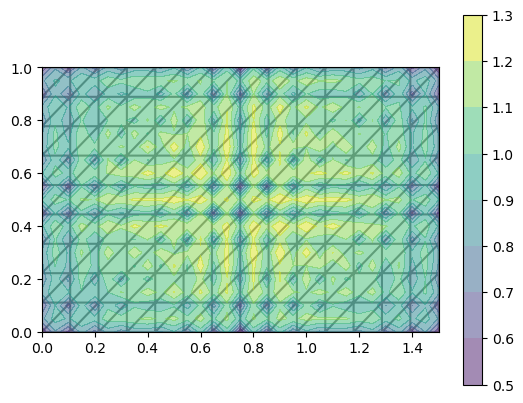

In [108]:
fig = fenics.plot(mesh)[0].figure
ax = fig.axes[0]
c = ax.contourf(X, Y, Z, alpha=0.5)
ax.set_aspect(1.0)
fig.colorbar(c);

In [116]:
for xy in mesh.coordinates():
    assert np.abs(u(xy, xy) - 0.5) < 1e-6

In [118]:
coords = mesh.coordinates()
k = 23
xy0, xy1 = coords[k,:], coords[k+1,:]
xy = (xy0 + xy1)/2
u(xy, xy)

0.9987623807246584